In [1]:
from collections import defaultdict
import os
import sys 
from tqdm import tqdm
import itertools
import utils.file_utils as utils
sys.path.append("/data/jeff-law/projects/fungcat-function-prediction/src")
#sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))))
import fungcat_settings as f_settings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

/home/jeffl/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# !cd /data/jeff-law/projects/fungcat-function-prediction
os.chdir("/data/jeff-law/projects/fungcat-function-prediction")

In [3]:
os.getcwd()

'/data/jeff-law/projects/fungcat-function-prediction'

In [4]:
# cv_file_template = "outputs/%s/all/%s/%s/cv-5folds-%sl%s-a%s-eps%s.txt"
cv_file_template = "outputs/%s/all/%s/%s/cv-5folds-%sl%s%s%s.txt"

def parse_files(versions, algorithms, exp_name, l_list, a_list, eps_list, maxi_list, unweighted_list,
               cv_file_template="outputs/%s/all/%s/%s/cv-5folds-%sl%s%s%s%s.txt",
               loso=False):
    params_fmax = {}
    for version in versions:
        for alg in algorithms:
            for l, a, eps, max_iters, unw in itertools.product(*[l_list, a_list, eps_list, maxi_list, unweighted_list]):
                cv_file = cv_file_template % (version, alg, exp_name, unw, 
                                              str(l).replace('.','_'), a, eps, max_iters)
#                                               str(l).replace('.','_'), str(a).replace('.','_'), str(eps).replace('.','_'))
    #             file_name = os.path.basename(cv_file).replace('cv-5folds-','')
                if os.path.isfile(cv_file):
                    print("reading %s" % (cv_file))
                    if loso is False:
                        goterm_fmax = {goterm: float(fmax) for goterm, fmax in utils.readColumns(cv_file, 1,2) if fmax != 'fmax'}
                    else:
                        goterm_fmax = {"%s-%s" % (sp, goterm): float(fmax) 
                                       for sp, goterm, fmax, num_ann in utils.readColumns(cv_file, 1,2,3,7) 
                                       if fmax != 'fmax' and int(num_ann) >= 10}
                    curr_key = ("%s %s %s, %s %s, %s" % (version, exp_name, alg, unw.replace('-',''), str(a), max_iters))
#                     curr_key = ("%s %s, l=%d, a=%s" % (alg, unw.replace('-',''), l, str(a)))
    #                 curr_key = ("lambda%d, alpha%s" % (l, str(a)))
                    params_fmax[curr_key] = goterm_fmax
                else:
                    print("%s doesn't exist" % (cv_file))
    print("%d total files read" % (len(params_fmax)))
    return params_fmax

In [5]:
def limit_to_h_goterms(df,
    h='bp', only_functions_file="inputs/only-functions/expc/expc-50-1000.txt"):
    # try splitting into bp and mf 
    lines = utils.readColumns(only_functions_file, 1, 3)
    bp = set()
    mf = set()
    for goid, gocat in lines:
        if gocat == 'P':
            bp.add(goid)
        elif gocat == 'F':
            mf.add(goid)
    print(len(bp), len(mf))
    if h == "bp":
        df2 = df[df.index.isin(bp)]
    elif h == 'mf':
        df2 = df[df.index.isin(mf)]
    else:
        print("%s not implemented" % (h))
        return
    print("%d %s goterms" % (len(df2), h))
    return df2

# Squeeze Evaluations - LOSO
We're repeating the squeeze evalations using LOSO instead of 5-fold CV

In [48]:
def plot_loso_comparison(df_loso_a, a_list, ylabel="Alpha", exp_type="alpha", color_palette="Set3", write_to_file=False, showfliers=True, whis=1.5):
    fig, ax = plt.subplots(figsize=(5,4))
    sns.boxplot(data=df_loso_a, orient="h", order=a_list, palette=color_palette, fliersize=2, showfliers=showfliers, whis=whis)
    # sns.boxplot(data=df, orient="h")
    # plt.xlabel(r'$F_{\mathrm{max}}$', fontsize=12, fontweight='bold')
#     plt.xlim(0,1.05)
    plt.xlabel(r'$F_{\mathrm{max}}$', fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    # plt.title("LOSO comparing alpha (1000 max iters) \n %s, %s \n %d %s GO terms with >= 10 ann, %s" % (
    plt.title("LOSO comparing %s \n %s, %s \n %d %s GO terms with >= 10 ann, %s" % (
        exp_type, versions[0], exp_name, 
        len(set(x.split('-')[1] for x in df_loso_a.index)), 
        h.upper(), '-'.join(algorithms)))
    # plt.tight_layout()
    out_file = "outputs/viz/sinksource-squeeze/loso/%s-%s-%s-compare-%s.pdf" % (versions[0], exp_name, '-'.join(algorithms), exp_type)
    # out_file = "outputs/viz/sinksource-squeeze/loso/%s-%s-%s-compare-maxi-a0_99.pdf" % (versions[0], exp_name, '-'.join(algorithms))
    utils.checkDir("outputs/viz/sinksource-squeeze/loso")
    if write_to_file:
        print("Writing to %s" % (out_file))
        plt.savefig(out_file, bbox_inches="tight")
    plt.show()
    plt.close()
    print("medians: %s" % (', '.join(["%s: %0.3f" % (str(a), df_loso_a[a].median()) for a in a_list])))
    # also write the medians to a file
    stat_file = out_file.replace('.pdf', '.txt')
    if write_to_file:
        print("writing medians to %s" % (stat_file))
        with open(stat_file, 'w') as out:
            out.write("#alpha/maxi\tmedian fmax\n")
            out.write(''.join(["%s\t%0.3f\n" % (str(a), df_loso_a[a].median()) for a in a_list]))
    return stat_file

In [61]:
# setup the parameters
# versions = ["2018_06-seq-sim-e0_1"]
# versions = ["2018_06-seq-sim-e0_1-string"]
# versions = ["2018_06-seq-sim-e0_1-string-700"]
versions = ["2018_09-s200-seq-sim-e0_1"]
algorithms = ["sinksource"]
# algorithms = ["genemania"]
# maxi_list = ["20-tol0_01", "20-tol0_0001", "20-tol1e-05", "20-tol1e-06", "20-tol1e-08"]
h = 'bp'
# a_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
# h = 'mf'
# a_list = [1.0, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5]
a_list = [1.0, 0.95]
# a_list = [1.0, 0.9]
# maxi_list = [1000]
# maxi_list = [400, 200, 50, 20, 10]
# maxi_list = [400, 200, 50, 20, 10, 5, 2, 1]
maxi_list = [1, 10, 2, 20, 200, 400, 5, 50, 1000]
# exp_name = "expc-rem-neg-comp-iea-50-1000%s-%s-use-neg" % ("-core" if "string" in versions[0] else "", h)
exp_name = "expc-50-1000%s-%s-use-neg" % ("-core" if "string" in versions[0] else "", h)
# exp_name = "expc-comp-rem-neg-iea-50-1000comp%s-%s-use-neg" % ("-core" if "string" in versions[0] else "", h)
# exp_name = "expc-comp-rem-neg-iea-50-1000iea%s-%s-use-neg" % ("-core" if "string" in versions[0] else "", h)
if versions[0] == "2018_09-s200-seq-sim-e0_1":
#     exp_name = "expc-comp-rem-neg-iea-50-1000comp%s-%s-use-neg" % ("-core" if "string" in versions[0] else "", h)
#     exp_name = "expc-comp-50-1000comp%s-%s-use-neg" % ("-core" if "string" in versions[0] else "", h)
    exp_name = "expc-comp-50-1000iea%s-%s-use-neg" % ("-core" if "string" in versions[0] else "", h)
l_list = [0]
# eps_list = ['-eps0_0']
eps_list = ['-eps0_0', '-eps0_0001']
# eps_list = ['']
unweighted = ['']
# exp_type = "ground-truth"
exp_type = "loso%s" % ("-gm2008" if "string" in versions[0] else "")
# exp_type = "loso%s" % ("-swsn" if "string" in versions[0] else "")
# cv_file_template = "outputs/%s/all/%s/%s/ground-truth-%sl%s%s%s%s.txt"
cv_file_template = "outputs/%s/all/%s/%s/" + exp_type + "-%sl%s%s%s%s.txt"

In [62]:
# read the files
params_fmax = parse_files(
    versions, algorithms, exp_name, l_list, 
    ['-a'+str(a).replace('.','_') for a in a_list], eps_list, 
#     maxi_list, unweighted,
    ['-maxi'+str(m).replace('.','_') for m in maxi_list], unweighted,
    cv_file_template=cv_file_template, loso=True)
df_loso_a = pd.DataFrame(params_fmax)
print("columns: ", df_loso_a.columns)
# just rename the maxi_list to a_list for the code below
if len(maxi_list) > 1:
    ylabel = "Max # Iterations"
    if algorithms[0] == 'genemania':
        a_list = [float(col.split('-maxi20-tol')[-1].replace('_','.')) for col in df_loso_a.columns]
    else:
        exp_type = "maxi-a%s" % (str(a_list[0]).replace('.','_'))
#         a_list = [int(col.split('-maxi')[-1]) for col in df_loso_a.columns]
        # if comparing both alpha and maxi, use this:
        a_list = ['a%s-%d' % (col.split('-a')[-1].split(', -maxi')[0], int(col.split('-maxi')[-1])) for col in df_loso_a.columns]
else:
    exp_type = "alpha"
    ylabel = "Alpha"
    a_list = a_list[::-1]
    # TODO
#     a_list = [int(col.split('-maxi')[-1]) for col in df_loso_a.columns]
print("renaming to %s" % (a_list))
df_loso_a.columns = a_list
a_list = sorted(a_list, reverse=True)
df_loso_a.head()

outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi1.txt doesn't exist
outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi10.txt doesn't exist
outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi2.txt doesn't exist
outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi20.txt doesn't exist
outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi200.txt doesn't exist
outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi400.txt doesn't exist
outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi5.txt doesn't exist
outputs/2018_09-s200-seq-sim-e0_1/all/sinksource/expc-comp-50-1000iea-bp-use-neg/loso-l0-a1_0-eps0_0-maxi50.txt doesn't

,a0_95-10,a0_95-200,a0_95-50,a1_0-1000
100226-GO:0000041,0.7879,0.8235,0.8235,0.7429
100226-GO:0000096,0.7742,0.7742,0.7742,0.6857
100226-GO:0000097,0.6923,0.6923,0.6923,0.6000
100226-GO:0000105,0.9167,0.9167,0.9167,0.8696
100226-GO:0000160,0.8914,0.8743,0.8743,0.8766


In [63]:
# make sure they all completed
for col in df_loso_a.columns:
    print("col %s median: %s, # rows: %d" % (col, df_loso_a[col].median(), df_loso_a[col].dropna().count()))
# print("dropping rows with an NA in any column.")
# df_loso_a = df_loso_a.dropna(how='any')

col a0_95-10 median: 0.7356, # rows: 73228
col a0_95-200 median: 0.7368, # rows: 73228
col a0_95-50 median: 0.7368, # rows: 73228
col a1_0-1000 median: 0.72705, # rows: 73228


In [54]:
# temp replace 20 with 10 for s200 iea. TODO: fix this later
df_loso_a["a0_95-20"] = df_loso_a["a0_95-10"]
a_list = ["a1_0-1000", "a0_95-200", "a0_95-50", "a0_95-20", "a0_95-10"]
# df_loso_a["a0_95-400"] = df_loso_a["a0_95-200"]

Writing to outputs/viz/sinksource-squeeze/loso/2018_09-s200-seq-sim-e0_1-expc-comp-50-1000comp-bp-use-neg-sinksource-compare-maxi-a1_0.pdf


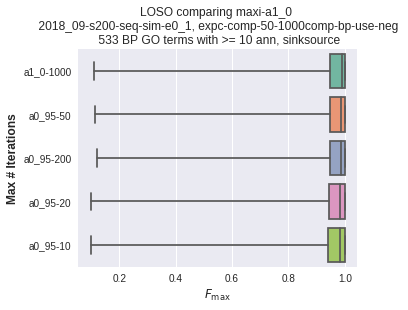

medians: a1_0-1000: 0.990, a0_95-50: 0.986, a0_95-200: 0.987, a0_95-20: 0.984, a0_95-10: 0.982
writing medians to outputs/viz/sinksource-squeeze/loso/2018_09-s200-seq-sim-e0_1-expc-comp-50-1000comp-bp-use-neg-sinksource-compare-maxi-a1_0.txt


In [59]:
# stat_file = plot_loso_comparison(df_loso_a, a_list, ylabel=ylabel, exp_type=exp_type, color_palette="Set2", write_to_file=False, whis=100)
stat_file = plot_loso_comparison(df_loso_a, a_list, ylabel=ylabel, exp_type=exp_type, color_palette="Set2", write_to_file=True, whis=100)

Writing to outputs/viz/sinksource-squeeze/loso/2018_06-seq-sim-e0_1-string-700-expc-50-1000-core-bp-use-neg-sinksource-compare-maxi-a0_9.pdf


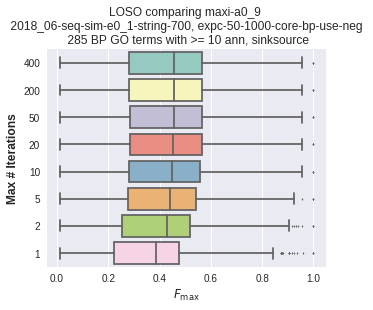

medians: 400: 0.455, 200: 0.455, 50: 0.455, 20: 0.453, 10: 0.449, 5: 0.441, 2: 0.428, 1: 0.385
writing medians to outputs/viz/sinksource-squeeze/loso/2018_06-seq-sim-e0_1-string-700-expc-50-1000-core-bp-use-neg-sinksource-compare-maxi-a0_9.txt


In [58]:
# stat_file = plot_loso_comparison(df_loso_a, a_list, ylabel=ylabel, exp_type=exp_type, write_to_file=False)
stat_file = plot_loso_comparison(df_loso_a, a_list, ylabel=ylabel, exp_type=exp_type, write_to_file=True)

In [48]:
# try printing the difference of the medians
alpha_1 = df_loso_a[max(a_list)].values
for a in a_list[1:]:
    print("%s, %s: median of differences: %0.3e" % (a_list[0], a, np.median(alpha_1 - df_loso_a[a].values)))

1.0, 0.99: median of differences: 0.000e+00
1.0, 0.95: median of differences: 0.000e+00
1.0, 0.9: median of differences: 0.000e+00
1.0, 0.8: median of differences: 1.800e-03
1.0, 0.7: median of differences: 6.800e-03
1.0, 0.6: median of differences: 1.000e-02
1.0, 0.5: median of differences: 1.470e-02


In [75]:
# test for statistical significance
from scipy.stats import kruskal, mannwhitneyu
if exp_type == 'alpha':
    name = exp_type
else:
    name = "maxi"

alpha_1 = df_loso_a["a1_0-1000"].values
# alpha_1 = df_loso_a[max(a_list)].dropna().values
# alpha_1 = df_loso_a[400].dropna().values
out_str = ""
# for a in a_list[:-1]:
for a in a_list[1:]:
    fmax_a = df_loso_a[a].dropna().values
    test_statistic, pval = mannwhitneyu(alpha_1, fmax_a, alternative='greater') 
    out_str += "%s\t%s\t%s\t%0.3e\n" % ('sinksource', '%s=%s' % (name, str(max(a_list))), '%s=%s' % (name, str(a)), pval)
# try printing the difference of the medians
alpha_1 = df_loso_a[max(a_list)].values
out_str += "#alg\talpha/maxi\talpha\maxi-2\tmedian of differences\n"
for a in a_list[1:]:
    out_str += "%s\t%s\t%s\t%0.3e\n" % ('sinksource', a_list[0], a, np.median(alpha_1 - df_loso_a[a].values))
print("appending to %s" % (stat_file))
with open(stat_file, 'a') as out:
    out.write("#alg\talpha/maxi\taplha/maxi-2\tpval\n")
    out.write(out_str)
print(out_str)

appending to outputs/viz/sinksource-squeeze/loso/2018_06-seq-sim-e0_1-string-expc-50-1000-core-bp-use-neg-sinksource-compare-maxi-a1_0.txt
sinksource	maxi=a1_0-1000	maxi=a0_95-50	2.793e-01
sinksource	maxi=a1_0-1000	maxi=a0_95-5	2.810e-02
sinksource	maxi=a1_0-1000	maxi=a0_95-400	2.806e-01
sinksource	maxi=a1_0-1000	maxi=a0_95-200	2.806e-01
sinksource	maxi=a1_0-1000	maxi=a0_95-20	2.241e-01
sinksource	maxi=a1_0-1000	maxi=a0_95-2	1.220e-04
sinksource	maxi=a1_0-1000	maxi=a0_95-1000	2.806e-01
sinksource	maxi=a1_0-1000	maxi=a0_95-10	1.304e-01
sinksource	maxi=a1_0-1000	maxi=a0_95-1	1.332e-11
#alg	alpha/maxi	alpha\maxi-2	median of differences
sinksource	a1_0-1000	a0_95-50	1.000e-04
sinksource	a1_0-1000	a0_95-5	1.310e-02
sinksource	a1_0-1000	a0_95-400	1.000e-04
sinksource	a1_0-1000	a0_95-200	1.000e-04
sinksource	a1_0-1000	a0_95-20	2.200e-03
sinksource	a1_0-1000	a0_95-2	2.480e-02
sinksource	a1_0-1000	a0_95-1000	1.000e-04
sinksource	a1_0-1000	a0_95-10	7.000e-03
sinksource	a1_0-1000	a0_95-1	4.620e-0

writing outputs/viz/sinksource-squeeze/compare-run-time-2018_06-seq-sim-e0_1-string-expc-rem-neg-comp-iea-50-1000-core-bp-use-neg-50-1000-loso-sinksource.pdf


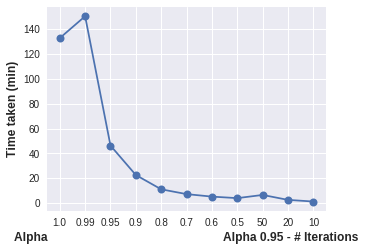

In [168]:
# also plot the time taken
# these times are from the log files here: /data/jeff-law/projects/fungcat-function-prediction/log/squeeze/compare-alpha
# grep "sinksource_total_time" 2018_06-seq-sim-e0_1-string-expc-rem-neg-comp-iea-50-1000-core-bp-sinksource-bp-a*
cv_time = {
    # these times are from rank-all with GO terms with 1-9 annotations in the left-out species
#     '1.0': 24753.18, '0.99': 24513.79,'0.95': 18244.07, '0.9': 9440.94, '0.8': 4777.73, '0.7': 3133.00,
#     '0.6': 2310.01,'0.5': 1749.15, '50': 1552.00, '20' : 614.41, '10' : 291.75,
    # these times are from rank-pos-neg from here: log/squeeze/./compare-alpha/2018_06-seq-sim-e0_1-string-expc-rem-neg-comp-iea-50-1000-core-bp-sinksource-squeeze-bp-a0.XX-maxi1000.log
    # the 10 and 20 iterations should be updated because they're really recording the time taken for 9 and 19 iterations.
    '1.0': 7967.74+(7967.74/999), '0.99': 9026.58,'0.95': 2776.46, '0.9': 1352.66, '0.8': 662.52, '0.7': 430.57,
    '0.6': 309.81,'0.5': 236.63, '50': 390.46+(390.46/49), '20' : 151.88+(151.88/19), '10' : 72.04+(72.04/9.),
}
# cv_time = {    # MF
#     '1.0': 2872.61, '0.99': 3147.64,'0.95': 977.91, '0.9': 485.37, '0.8': 240.94, '0.7': 157.49,
#     '0.6': 114.08,'0.5': 88.38, '50': 141.229, '20' : 54.817, '10' : 25.926,
# }
order = ['1.0', '0.99', '0.95', '0.9', '0.8', '0.7', '0.6', '0.5', '50', '20', '10']
# s = pd.Series(cv_time, index=order)
# print(s.values)
fig, ax = plt.subplots(figsize=(5,3.75))
ax.plot(range(len(order)), [cv_time[x]/60 for x in order], marker='o', markersize=8)
locs, labels = plt.xticks()
# ax.set_yscale("log", basey=2)
plt.xticks(list(range(len(order))), order)
# locs, labels = plt.yticks()
# plt.yticks(locs[1:-1], [str(2**(i+1)) for i in range(len(labels))])
# plt.xticks(locs, labels)
plt.xlabel("Alpha %s Alpha 0.95 - # Iterations" % (' '*50), fontsize=12, fontweight='bold')
plt.ylabel("Time taken (min)", fontsize=12, fontweight='bold')
out_file = "outputs/viz/sinksource-squeeze/compare-run-time-%s-%s-50-1000-loso-%s.pdf" % (versions[0], exp_name, '-'.join(algorithms))
print("writing %s" % out_file)
# plt.savefig(out_file)
plt.show()
plt.close()

writing outputs/viz/sinksource-squeeze/compare-run-time-2018_09-s200-seq-sim-e0_1-expc-comp-50-1000iea-bp-use-neg-50-1000-loso-sinksource.pdf


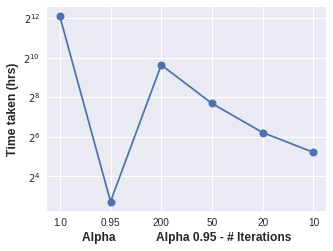

In [66]:
# these are the times for the 200 species, EXPC+COMP recov COMP
if 'expc-comp-50-1000comp' in exp_name:
    total_time = {
        # BP
        # TODO I'm estimating the values that didn't finish for now
        # The 0.95 value is how long it took for 50 random GO terms
    #     '1.0': 563.5*6951, '0.95': 58512.66, '200': 114.1*6951, '50': 197243.6, '20': 76650.6+3969.9, '10': 35722.5+3969.9, '5': 16239.4+3969.9, '2': 3969.9*2, '1': 3969.9,
        '1.0': 563.5*6951, 
        '0.95': 58512.66/2.5, # divide by 3 to get 5% of terms instead of 15% of terms
        '200': 114.1*6951, '50': 197243.6, '20': 76650.6+3969.9, '10': 35722.5+3969.9,
    }
    # get into hours
    total_time = {x: total_time[x]/60/60 for x in total_time}
elif 'expc-comp-50-1000iea' in exp_name:
    total_time = {
        # BP
        # TODO I'm estimating the values that didn't finish for now
        # The 0.95 value is how long it took for 50 random GO terms
        '1.0': 4374.687, 
        '0.95': 6.659, # divide by 3 to get 5% of terms instead of 15% of terms
        '200': 794.995, '50': 206.182, '20': 37.240*2, '10': 37.240,
    }
# order = ['1.0', '0.95', '200', '50', '20', '10', '5', '2', '1']
order = ['1.0', '0.95', '200', '50', '20', '10']
# s = pd.Series(cv_time, index=order)
# print(s.values)
fig, ax = plt.subplots(figsize=(5,3.75))
ax.plot(range(len(order)), [total_time[x] for x in order], marker='o', markersize=8)
locs, labels = plt.xticks()
ax.set_yscale("log", basey=2)
plt.xticks(list(range(len(order))), order)
# locs, labels = plt.yticks()
# plt.yticks(locs[1:-1], [str(2**((i*2)-1)) for i in range(len(labels))])
# plt.xticks(locs, labels)
plt.xlabel("Alpha %s Alpha 0.95 - # Iterations" % (' '*10), fontsize=12, fontweight='bold')
plt.ylabel("Time taken (hrs)", fontsize=12, fontweight='bold')
out_file = "outputs/viz/sinksource-squeeze/compare-run-time-%s-%s-50-1000-loso-%s.pdf" % (versions[0], exp_name, '-'.join(algorithms))
print("writing %s" % out_file)
plt.savefig(out_file)
plt.show()
plt.close()

In [ ]:
# also make a scatterplot comparing alpha=1 to alpha=0.8
# df2[[1.0, 0.8]].plot.scatter(0.8, 1.0)
df3 = df_loso_a[[1.0, 0.8]]
alpha_comp = "alpha 1.0 Fmax - alpha 0.8 Fmax"
xlabel = "alpha 1.0 Fmax"
# df3[x] = df3[1.0]
df3[alpha_comp] = df3[1.0] - df3[0.8]
grid = sns.jointplot(x=1.0, y=alpha_comp, data=df3,
              stat_func=None, annot_kws=dict(fontsize=18), # joint_kws={"s": 20}, marginal_kws=dict(bins=40),
             )
# change the font
# sns.axes_style()
grid.set_axis_labels(xlabel=xlabel, ylabel=alpha_comp, fontsize=12, fontweight='bold')

out_file = "outputs/viz/sinksource-squeeze/loso/%s-%s-%s-compare-%s-scatter.pdf" % (versions[0], exp_name, '-'.join(algorithms), exp_type)
print("Writing to %s" % (out_file))
plt.savefig(out_file)

print("1.0 > 0.8: %0.2f, 1.0 < 0.8: %0.2f, == %0.2f" % (
    len(df3[df3[alpha_comp] > 0]) / float(len(df3)), 
    len(df3[df3[alpha_comp] < 0]) / float(len(df3)), 
    len(df3[df3[alpha_comp] == 0]) / float(len(df3))))

In [39]:
# test for statistical significance
from scipy.stats import kruskal, mannwhitneyu

alpha_1 = df_loso_a[20].values
for a in a_list[1:]:
    fmax_a = df_loso_a[a].values
    test_statistic, pval = mannwhitneyu(alpha_1, fmax_a, alternative='greater') 
    print("%s\t%s\t%s\t%0.3f" % ('sinksource', 'max_iters=400', 'max_iters='+str(a), pval))

sinksource	max_iters=400	max_iters=200	0.182
sinksource	max_iters=400	max_iters=50	0.506
sinksource	max_iters=400	max_iters=20	0.500
sinksource	max_iters=400	max_iters=10	0.310
sinksource	max_iters=400	max_iters=5	0.094
sinksource	max_iters=400	max_iters=2	0.238
sinksource	max_iters=400	max_iters=1	0.014
